# 4.2 Inference given i.i.d. trials on a drift-diffusion model from psychophysics

In this tutorial, we focus on an application of neural likelihood estimation, and
showcase that we can still efficiently sample posteriors using MCMC after learning the
likelihood. Additionally, we showcase the ability of the neural likelihood estimation
to be used when there is a varying number of trials, and also show an example of a 
mixed density estimator - which estimates the density of a mix of continuous and 
categorical variables.

In [1]:
from ddm_utils import (
    encode_zero_choice_as_negative_rts,
    parallel_simulator,
    simulate_ddm_collapsing,
)


import sys

import torch

sys.path.append(".")
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sbi.analysis import pairplot
from sbi.inference import MNLE
from sbi.utils import BoxUniform
from sbi.utils.diagnostics_utils import get_posterior_samples_on_batch
from scipy.stats import binom


# Colorblind color palette
colors = [
    "#377eb8",
    "#ff7f00",
    "#4daf4a",
    "#f781bf",
    "#a65628",
    "#984ea3",
    "#999999",
    "#e41a1c",
    "#dede00",
]
colors_red = mpl.cm.Reds(np.linspace(0.3, 1, 5))
tue = (165 / 255, 30 / 255, 55 / 255)
gold = (180 / 255, 160 / 255, 105 / 255)
dark = (50 / 255, 65 / 255, 75 / 255)



link_to_mplrc = "../../.matplotlibrc"
link_to_data = "../../paper/fig9_drift_diffusion/data/"
plt.style.use(link_to_mplrc)

### Generate simulations

As always, we need to generate a dataset of training simulations to train the density
estimator. For this application, we simulated 200,000 single trials. We provide an 
option to load the results of these trials instead of simulating again here.

In [2]:
num_simulations = 200000
num_posterior_samples = 1000
num_sbc_samples = 200
num_workers = 10
num_trials = 100
seed = 42


# prior = BoxUniform(
#     low=torch.tensor([-2.5, 0.25, -0.25, 0.05, -1.0]),
#     high=torch.tensor([2.5, 1.0, 0.25, 0.95, -0.1]),
# )

# simulator = parallel_simulator(
#     num_workers=num_workers, show_progress=True, seed=seed
# )(simulate_ddm_collapsing)

# # Run simulations
# theta = prior.sample((num_simulations,))
# x = simulator(theta)

# Load simulations
with open(link_to_data + "sbi_ddm_collapsing_prior_theta_x.pkl", "rb") as f:
    prior, theta, x = pickle.load(f)

### Training a Mixed Neural Likelihood Estimator

The syntax is identical to the the syntax for training Neural Posterior Estimators, but
recall that we are estimating the likelihood of a single trial here, not estimating a 
posterior directly.

Again, we provide the option to load a trained model here instead.

In [3]:
#train a density estimator
# inferer = MNLE()
# density_estimator = inferer.append_simulations(theta, x).train()

#alternatively, load an already trained density estimator
inferer = MNLE()
density_estimator = torch.load(link_to_data + "ddm_collapsing_estimator.pt")


/var/folders/4q/8fx0bbzx37x2pnkf3h36dsgm0000gn/T/ipykernel_50494/570064376.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  density_estimator = torch.load(link_to_data + 

### Building the posterior

As we learned a likelihood model, we cannot sample the posterior directly as we would for
NPE. But, we have now a surrogate likelihood model that can be evaluated in batches with
a single forward pass - and so we can very efficiently sample the posterior using MCMC. 

In [4]:
mcmc_parameters = {
    "num_chains": 100,
    "thin": 2,
    "warmup_steps": 500,
    "init_strategy": "sir",
}
posterior = inferer.build_posterior(
    prior=prior, density_estimator=density_estimator, mcmc_parameters=mcmc_parameters
)

In [5]:
# Generating observed data
seed = 42
simulator = parallel_simulator(num_workers=10, show_progress=True, seed=seed)(
    simulate_ddm_collapsing
)

num_trials = 100 #we generate two observations, one with 100 and another with 200 trials.
theta_o1 = torch.tensor([[-0.125, 0.35, -0.2, 0.5, -0.7]])
theta_o2 = torch.tensor([[0.125, 0.55, 0.2, 0.3, -0.5]])
x_o1 = simulator(theta_o1.repeat(num_trials, 1))
x_o2 = simulator(theta_o2.repeat(2 * num_trials, 1))

100%|██████████| 200/200 [00:00<00:00, 616.18it/s]


### Sample the posterior

The likelihood over multiple i.i.d. trials is simply the product of the likelihoods of
the individual trials (or the sum of the log-likelihoods of the trials is the log-
likelihood of the multitrial observation). Therefore, even though we have observations
with a different number of trials, we can still use our pretrained likelihood estimator
to sample from the posterior with MCMC.

We also provide an option to load previously generated samples to save time here.

In [6]:
# posterior_samples1 = posterior.sample((num_posterior_samples,), x=x_o1)
# posterior_samples2 = posterior.sample((num_posterior_samples,), x=x_o2)


with open(link_to_data + "ddm_collapsing_posterior_samples.pkl", "rb") as f:
    posterior_samples = torch.load(f)
    posterior_samples1 = posterior_samples["posterior_samples1"]
    posterior_samples2 = posterior_samples["posterior_samples2"]

/var/folders/4q/8fx0bbzx37x2pnkf3h36dsgm0000gn/T/ipykernel_50494/1787144132.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  posterior_samples = torch.load(f)


### Visualizing the Posterior

Here we show the pairplots of the posteriors for the two subjects, together with the 
true values of $\theta$ used to generate the observations.

/var/folders/4q/8fx0bbzx37x2pnkf3h36dsgm0000gn/T/ipykernel_50494/2544520604.py:17: DeprecationWarning: you passed deprecated arguments **kwargs: ['samples_colors', 'kde_offdiag', 'contour_offdiag', 'scatter_offdiag', 'hist_diag', 'points_offdiag', 'points_diag', 'points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  pairplot(


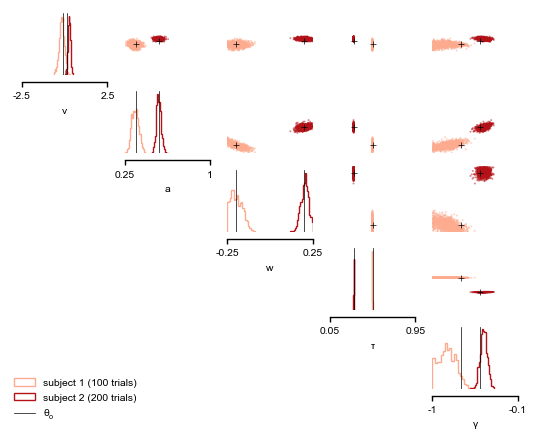

In [7]:
nbins = 100
histtype = "step"
repeats = 50
# how to use latex typesetting
# mpl.rcParams["text.usetex"] = True
# mpl.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
labels = [r"$v$", r"$a$", r"$w$", r"$\tau$", r"$\gamma$"]
num_params = len(labels)
limits = [
    [prior.base_dist.low[i].item(), prior.base_dist.high[i].item()]
    for i in range(prior.base_dist.low.shape[0])
]

# panel c
with mpl.rc_context(fname=link_to_mplrc):
    fig, ax = plt.subplots(num_params, num_params)
    pairplot(
        [posterior_samples1, posterior_samples2],
        points=[theta_o1, theta_o2],
        limits=limits,
        ticks=limits,
        samples_colors=[colors_red[0], colors_red[-2]],
        diag="hist",
        upper="scatter",
        kde_offdiag=dict(bw_method="scott", bins=50),
        contour_offdiag=dict(levels=[0.95], percentile=True),
        scatter_offdiag=dict(s=2),
        hist_diag=dict(bins=20, histtype=histtype),
        points_offdiag=dict(
            marker="+", markersize=4, mew=0.5
        ),  # Reduced edge width with 'mew'
        points_diag=dict(linewidth=0.5),
        points_colors=["k", "k"],
        fig=fig,
        axes=ax,
        labels=labels,
    )
    # mpl.rcParams["text.usetex"] = False
    plt.sca(ax[0, 0])
    plt.legend(
        [
            "subject 1 (100 trials)",
            "subject 2 (200 trials)",
            r"$\theta_o$",
        ],
        bbox_to_anchor=(-0.2, -4.5),
        # handlelength=0.6,
        loc=2,
    )
    plt.show()

### Posterior Predictive Checks

As for the previous examples, we can perform posterior predictive checks by simulating
samples from our posterior, and verifying that we obtain predictions similar to our
observations.

We compare the posterior predictives to the prior predictives to highlight that our 
posterior is much more constrained to the observations.

In [8]:
# Generate predictive samples
num_predictive_samples = 1000
x_o_dist1 = simulator(theta_o1.repeat(num_predictive_samples, 1))
x_o_dist1 = encode_zero_choice_as_negative_rts(x_o_dist1)
x_o_dist2 = simulator(theta_o2.repeat(num_predictive_samples, 1))
x_o_dist2 = encode_zero_choice_as_negative_rts(x_o_dist2)

posterior_pred1 = encode_zero_choice_as_negative_rts(simulator(posterior_samples1))
posterior_pred2 = encode_zero_choice_as_negative_rts(simulator(posterior_samples2))

prior_pred = encode_zero_choice_as_negative_rts(x[:num_predictive_samples])

100%|██████████| 1000/1000 [00:01<00:00, 753.04it/s]


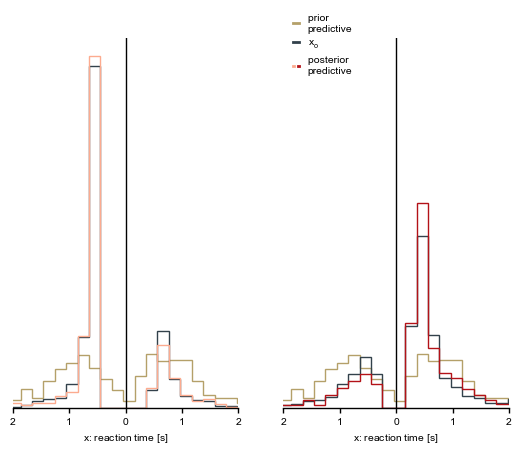

In [9]:
with mpl.rc_context(fname=link_to_mplrc):
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

    # plot for each subject
    plt.sca(ax[0])
    _, bins = np.histogram(prior_pred.numpy(), bins=50)
    for sample, color in zip(
        [prior_pred, x_o_dist1, posterior_pred1],
        [gold, dark, colors_red[0]],
    ):
        plt.hist(
            sample.numpy(),
            bins=bins,
            density=True,
            histtype=histtype,
            color=color,
            # linewidth=linewidth,
        )

    ax[0].spines["left"].set_visible(False)
    plt.yticks([])
    plt.xlabel("$x$: reaction time [s]")
    ticks = np.array([-2, -1, 0, 1, 2])
    plt.xticks(ticks, abs(ticks))
    plt.xlim([ticks.min(), ticks.max()])

    # Arrows
    plt.axvline(0, color="k")
    axis_setoff = -0.02

    plt.sca(ax[1])
    for sample, color in zip(
        [prior_pred, x_o_dist2, posterior_pred2],
        [gold, dark, colors_red[-2]],
    ):
        plt.hist(
            sample.numpy(),
            bins=bins,
            density=True,
            histtype=histtype,
            color=color,
            # linewidth=linewidth,
        )

    ax[1].spines["left"].set_visible(False)
    plt.yticks([])
    plt.xlabel("$x$: reaction time [s]")
    ticks = np.array([-2, -1, 0, 1, 2])
    plt.xticks(ticks, abs(ticks))
    plt.xlim([ticks.min(), ticks.max()])

    # Create handles for the legend
    prior_handle = plt.Line2D([0], [0], color=gold, lw=2)
    x_o_handle = plt.Line2D([0], [0], color=dark, lw=2)
    post_handle1 = plt.Line2D([0], [0], color=colors_red[0], lw=2)
    post_handle2 = plt.Line2D([0], [0], color=colors_red[-2], lw=2)

    # Group the two posterior handles
    post_handles = (post_handle1, post_handle2)

    # Create the legend with proper grouping
    handles = [prior_handle, x_o_handle, post_handles]
    _labels = ["prior \npredictive", "$x_o$", "posterior \npredictive"]

    # Add legend with custom handler
    fig.legend(
        handles=handles,
        labels=_labels,
        bbox_to_anchor=(0.67, 0.95),
        handlelength=0.6,
        frameon=False,
        handler_map={tuple: plt.matplotlib.legend_handler.HandlerTuple(ndivide=None)},
    )

    # Arrows
    plt.axvline(0, color="k")
    axis_setoff = -0.02

    # plt.savefig("fig/posterior_predictives.svg")
    plt.show()

### Simulation-based Calibration Checks

We can also perform simulation-based calibration checks to validate our learned
posteriors. As before, we need to generate a new set of simulations from our prior. 
Here, we show the simulation-based calibration in terms of the 1-dimensional marginal 
distributions, expected coverage of the posterior, and the Test of Accuracy with Random
Points (TARP).

Here, we generate 200 samples from the joint distribution and sample 1000 posterior
samples for each. Alternatively, we provide the saved results of this to save time.

In [10]:
# Generate samples from the joint distribution for simulation-based calibration

# thetas = prior.sample((num_sbc_samples,))
# xs = []
# for i in range(num_sbc_samples):
#     x = simulator(thetas[i].repeat(num_trials, 1))
#     xs.append(x)
# xs = torch.cat(xs, dim=0)

# posterior_samples = get_posterior_samples_on_batch(
#     xs,
#     posterior,
#     (num_posterior_samples,),
#     num_workers,
#     show_progress_bar=False,
#     use_batched_sampling=False,
# )



# Alternatively, load saved samples
with open(link_to_data + "ddm_collapsing_calibration_samples.pt", "rb") as fh:
    thetas, xs, sbc_posterior_samples = pickle.load(fh).values()


In [11]:


with open(link_to_data + "ddm_collapsing_diagnostics.pt", "rb") as f:
    ranks, daps = pickle.load(f).values()
    num_sbc_samples = len(ranks)

Here, we use the joint distribution and posterior samples to calculate the ranks
for the SBC marginal ranks, the expected coverage ranks, and the TARP ranks

In [12]:
from sbi.diagnostics.sbc import _run_sbc
from sbi.diagnostics.tarp import _run_tarp, get_tarp_references

marginal_ranks = _run_sbc(
    thetas,
    xs,
    posterior_samples=sbc_posterior_samples,
    posterior=posterior,
    reduce_fns="marginals",
)
ep_ranks = _run_sbc(
    thetas,
    xs,
    posterior_samples=sbc_posterior_samples,
    posterior=posterior,
    reduce_fns=posterior.potential,
)

tarp_references = get_tarp_references(thetas)
ecp, alpa = _run_tarp(
    posterior_samples=sbc_posterior_samples,
    thetas=thetas,
    references=tarp_references,
    num_bins=100,
)

Calculating ranks for 200 sbc samples.:   0%|          | 0/200 [00:00<?, ?it/s]

Calculating ranks for 200 sbc samples.:   0%|          | 0/200 [00:00<?, ?it/s]

### Visualizing Simulation-Based Calibration Ranks

We see that all calibration checks indicate that the ranks are approximately uniform, 
providing evidence for a well-calibrated posterior.

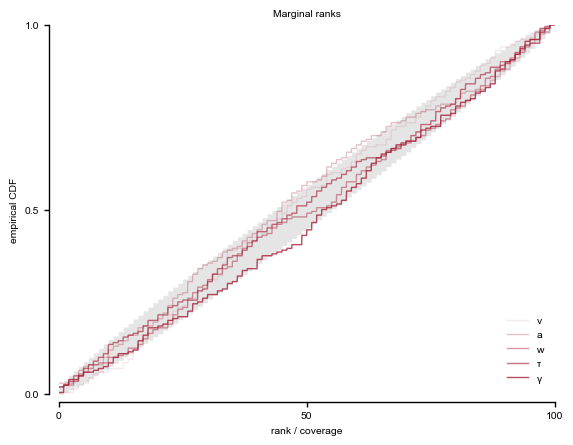

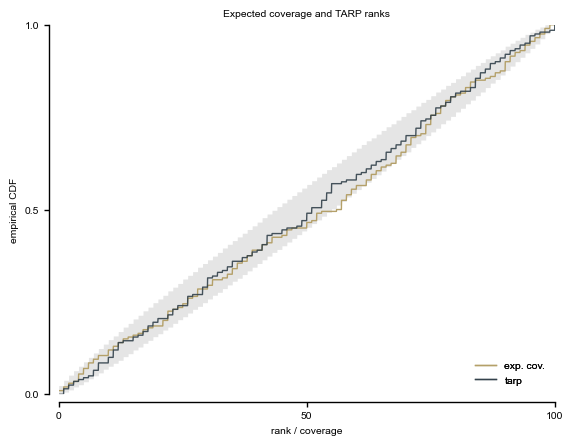

In [13]:
with mpl.rc_context(fname=link_to_mplrc):
    fig1, ax1 = plt.subplots(1, 1)
    alphas = np.linspace(0.1, 0.8, num_params)
    lines = []
    for jj in range(num_params):
        hist, *_ = np.histogram(marginal_ranks[:, jj], bins=nbins, density=False)
        histcs = hist.cumsum()
        line = ax1.plot(
            np.linspace(0, nbins, repeats * nbins),
            np.repeat(histcs / histcs.max(), repeats),
            label=labels[jj],
            color=tue,
            alpha=alphas[jj],
        )
        lines.append(line[0])

    hb = binom(num_sbc_samples, p=1 / nbins).ppf(0.5) * np.ones(nbins)
    hbb = hb.cumsum() / hb.sum()
    hbb[-1] -= 1e-9
    lower = [binom(num_sbc_samples, p=p).ppf(0.005) for p in hbb]
    upper = [binom(num_sbc_samples, p=p).ppf(0.995) for p in hbb]

    ax1.fill_between(
        x=np.linspace(0, nbins, repeats * nbins),
        y1=np.repeat(lower / np.max(lower), repeats),
        y2=np.repeat(upper / np.max(lower), repeats),
        color="grey",
        linewidth=0,
        alpha=0.2,
    )
    ax1.set_yticks(np.linspace(0, 1, 3))
    ax1.set_ylabel("empirical CDF")
    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, nbins)
    ax1.set_xticks(np.linspace(0, nbins, 3))
    ax1.spines["left"].set_position(("axes", axis_setoff))
    ax1.spines["bottom"].set_position(("axes", axis_setoff))
    ax1.set_xlabel("rank / coverage")
    ax1.legend(
        handles=lines,
        loc="lower right",
    )
    ax1.set_title("Marginal ranks")

with mpl.rc_context(fname=link_to_mplrc):
    fig2, ax2 = plt.subplots(1, 1)
    hist, *_ = np.histogram(ep_ranks, bins=nbins, density=False)
    histcs = hist.cumsum()
    ep_line = ax2.plot(
        np.linspace(0, nbins, repeats * nbins),
        np.repeat(histcs / histcs.max(), repeats),
        color=gold,
        alpha=1.0,
        label="exp. cov.",
    )
    tarp_line = ax2.plot(
        np.linspace(0, len(ecp), repeats * len(ecp)),
        np.repeat(ecp / ecp.max(), repeats),
        color=dark,
        alpha=0.9,
        label="tarp",
    )
    new_legend = ax2.legend(
        handles=[ep_line[0], tarp_line[0]],
        loc="lower right",
    )
    ax2.add_artist(new_legend)

    hb = binom(num_sbc_samples, p=1 / nbins).ppf(0.5) * np.ones(nbins)
    hbb = hb.cumsum() / hb.sum()
    hbb[-1] -= 1e-9
    lower = [binom(num_sbc_samples, p=p).ppf(0.005) for p in hbb]
    upper = [binom(num_sbc_samples, p=p).ppf(0.995) for p in hbb]

    ax2.fill_between(
        x=np.linspace(0, nbins, repeats * nbins),
        y1=np.repeat(lower / np.max(lower), repeats),
        y2=np.repeat(upper / np.max(lower), repeats),
        color="grey",
        linewidth=0.0,
        alpha=0.2,
    )
    ax2.set_yticks(np.linspace(0, 1, 3))
    ax2.set_ylabel("empirical CDF")
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, nbins)
    ax2.set_xticks(np.linspace(0, nbins, 3))
    ax2.spines["left"].set_position(("axes", axis_setoff))
    ax2.spines["bottom"].set_position(("axes", axis_setoff))
    ax2.set_xlabel("rank / coverage")
    ax2.set_title("Expected coverage and TARP ranks")
    plt.show()